## All stations models

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math
from scipy import stats
import re
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline
# %run model_utils.ipynb

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
### Set fixed variables
input_path = 'data/PROCESSED/STATIONS_CLEAN'
path = 'data/PROCESSED/MODEL_OUTPUTS'

## sampling frequency
sample_freq = 60 #(time in minutes)
steps=int(sample_freq/5)
time_steps = int(60/sample_freq)
#60min - 12 steps
#30min - 6 steps
#15min - 3 steps
#5min - 1 step

MAX_EPOCHS = 20

In [64]:
files_ids = {'guadalupe':'guadalupe_validation.csv',
         'banos':'banos_validation.csv',
         'aeropuerto': 'aeropuerto_validation.csv',
         'quisapincha':'quisapincha_validation.csv',
         'chiquiurco':'chiquiurco_validation.csv',
         'AJSucre':'AJSucre_validation.csv',
         'JAlvarez':'JAlvarez_validation.csv',
         'pfc-hgpt':'pfc-hgpt_validation.csv',
         'calamaca':'calamaca_validation.csv',
         'mulaCorral':'mulaCorral_validation.csv',
         'pampasSalasaca':'pampasSalasaca_validation.csv',
         'tasinteo':'tasinteo_validation.csv',
         'pisayambo':'pisayambo_validation.csv',
         'cunchibamba':'cunchibamba-hgpt_validation.csv'
         }
## cuchimbamba??

In [65]:
def selectCols(df):
  d = dict(zip(df.columns[1:20],df.columns[1:20]+f'_{station[0:3]}'))
  #df = df[['Date_Time', 'ATAvg', 'RHAvg','WDAvg','WSAvg','WAvgx', 'WAvgy','Day_sin', 'Day_cos', 'Year_sin', 'Year_cos']]
  df = df[['Date_Time', 'ATAvg', 'RHAvg','WSAvg','WAvgx','Day_sin', 'Day_cos']]
  df.rename(columns=d, inplace= True)
  df.set_index('Date_Time', inplace =True)
  df.index = pd.to_datetime(df.index)
  return df

In [66]:
### combine all stations in one df
for idx, station in enumerate(files_ids.keys()):
    if idx == 0:
        df = pd.read_csv(f'{input_path}/{station}_validation.csv')
        merged = selectCols(df)
    else:
        df1 = pd.read_csv(f'{input_path}/{station}_validation.csv')
        df1 = selectCols(df1)
        merged=pd.merge(merged,df1, how='inner', left_index=True, right_index=True)
    

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [67]:
merged.columns

Index(['ATAvg_gua', 'RHAvg_gua', 'WSAvg_gua', 'WAvgx_gua', 'Day_sin_gua',
       'Day_cos_gua', 'ATAvg_ban', 'RHAvg_ban', 'WSAvg_ban', 'WAvgx_ban',
       'Day_sin_ban', 'Day_cos_ban', 'ATAvg_aer', 'RHAvg_aer', 'WSAvg_aer',
       'WAvgx_aer', 'Day_sin_aer', 'Day_cos_aer', 'ATAvg_qui', 'RHAvg_qui',
       'WSAvg_qui', 'WAvgx_qui', 'Day_sin_qui', 'Day_cos_qui', 'ATAvg_chi',
       'RHAvg_chi', 'WSAvg_chi', 'WAvgx_chi', 'Day_sin_chi', 'Day_cos_chi',
       'ATAvg_AJS', 'RHAvg_AJS', 'WSAvg_AJS', 'WAvgx_AJS', 'Day_sin_AJS',
       'Day_cos_AJS', 'ATAvg_JAl', 'RHAvg_JAl', 'WSAvg_JAl', 'WAvgx_JAl',
       'Day_sin_JAl', 'Day_cos_JAl', 'ATAvg_pfc', 'RHAvg_pfc', 'WSAvg_pfc',
       'WAvgx_pfc', 'Day_sin_pfc', 'Day_cos_pfc', 'ATAvg_cal', 'RHAvg_cal',
       'WSAvg_cal', 'WAvgx_cal', 'Day_sin_cal', 'Day_cos_cal', 'ATAvg_mul',
       'RHAvg_mul', 'WSAvg_mul', 'WAvgx_mul', 'Day_sin_mul', 'Day_cos_mul',
       'ATAvg_pam', 'RHAvg_pam', 'WSAvg_pam', 'WAvgx_pam', 'Day_sin_pam',
       'Day_cos_pam', 

In [68]:
merged.head()

,ATAvg_gua,RHAvg_gua,WSAvg_gua,WAvgx_gua,Day_sin_gua,Day_cos_gua,ATAvg_ban,RHAvg_ban,WSAvg_ban,WAvgx_ban,...,WSAvg_pis,WAvgx_pis,Day_sin_pis,Day_cos_pis,ATAvg_cun,RHAvg_cun,WSAvg_cun,WAvgx_cun,Day_sin_cun,Day_cos_cun
Date_Time,,,,,,,,,,,,,,,,,,,,,
2013-05-09 11:45:00,21.708,55.150,4.195,-4.191908,6.540313e-02,-0.997859,23.982,61.768,4.765,-0.759371,...,4.63,-3.217721,6.540313e-02,-0.997859,17.55,64.24,4.21,-2.411445,6.540313e-02,-0.997859
2013-05-09 11:50:00,21.728,53.284,4.195,-4.191908,4.361939e-02,-0.999048,24.292,60.124,4.765,-0.759371,...,4.02,-2.793788,4.361939e-02,-0.999048,17.59,62.67,4.22,-2.417173,4.361939e-02,-0.999048
2013-05-09 11:55:00,22.090,51.676,4.195,-4.191908,2.181489e-02,-0.999762,24.532,59.028,4.765,-0.759371,...,4.36,-3.030079,2.181489e-02,-0.999762,17.69,63.43,4.29,-2.457268,2.181489e-02,-0.999762
2013-05-09 12:00:00,22.190,51.590,4.630,-4.629973,1.373671e-12,-1.000000,24.454,59.820,5.060,-0.907346,...,5.79,-3.925430,1.373671e-12,-1.000000,17.74,65.67,4.16,-2.545388,1.373671e-12,-1.000000
2013-05-09 12:05:00,22.106,50.402,4.630,-4.629973,-2.181489e-02,-0.999762,24.580,59.690,5.060,-0.907346,...,6.03,-4.088142,-2.181489e-02,-0.999762,17.85,64.45,4.20,-2.569863,-2.181489e-02,-0.999762


In [69]:
print(f'len = {len(merged)}')
merged.drop_duplicates(keep = 'first',inplace=True)
print(f'len (after duplicate drop = {len(merged)}')

len = 623263
len (after duplicate drop = 623263


In [70]:
merged.isnull().values.any()

False

In [71]:
#delete outliers an dfill with the meadian value
Q1 = merged.quantile(0.25)
Q3 = merged.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

ATAvg_gua       4.860000
RHAvg_gua      29.450000
WSAvg_gua       3.660000
WAvgx_gua       3.830788
Day_sin_gua     1.414214
                 ...    
RHAvg_cun      27.330000
WSAvg_cun       2.770000
WAvgx_cun       2.108025
Day_sin_cun     1.414214
Day_cos_cun     1.414214
Length: 84, dtype: float64


In [72]:
for i,col in enumerate(merged.columns):
    merged[col] = np.where((merged[col] < (Q1[i] - 1.5 * IQR[i]))|(merged[col] > (Q3[i] + 1.5 * IQR[i])), np.nan, merged[col])

In [73]:
merged.isnull().values.any()

True

In [74]:
merged['month']= merged.index.month
merged['hour']= merged.index.hour
for v in merged.columns:
    merged[v] = merged.groupby(['hour','month'])[v].transform(lambda x: x.fillna(x.median()))


In [75]:
merged.drop(columns=['month','hour'],inplace=True)

In [76]:
merged.isnull().values.any()

False

In [77]:
### Subsample to get data for every hour (starting from index 0, get 12 steps)
df = merged[0::steps]

In [78]:
print(f'starts at = {df.index.min().date()}')
print(f'ends at = {df.index.max().date()}')

starts at = 2013-05-09
ends at = 2019-04-12


In [79]:
## Select variables of interest
r = re.compile(f'ATAvg.*') # only csv files
temp = list(filter(r.match, list(df.columns))) 

r = re.compile(f'RHAvg.*') # only csv files
rh = list(filter(r.match, list(df.columns))) 

In [80]:
### Split data into 70%, 20%, 10% split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [81]:
# ### Normalize the data  ### ROOM TO MAKE TESTS (this is just an average)
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

In [82]:
df.head()

,ATAvg_gua,RHAvg_gua,WSAvg_gua,WAvgx_gua,Day_sin_gua,Day_cos_gua,ATAvg_ban,RHAvg_ban,WSAvg_ban,WAvgx_ban,...,WSAvg_pis,WAvgx_pis,Day_sin_pis,Day_cos_pis,ATAvg_cun,RHAvg_cun,WSAvg_cun,WAvgx_cun,Day_sin_cun,Day_cos_cun
Date_Time,,,,,,,,,,,,,,,,,,,,,
2013-05-09 11:45:00,21.708,55.150,4.195,-4.191908,0.065403,-0.997859,23.982,61.768,4.765,-0.759371,...,4.63,-3.217721,0.065403,-0.997859,17.55,64.24,4.21,-2.411445,0.065403,-0.997859
2013-05-09 12:45:00,21.000,61.836,4.630,-4.629973,-0.195090,-0.980785,22.336,65.680,5.060,-0.907346,...,5.47,-3.708481,-0.195090,-0.980785,18.08,64.43,5.03,-3.077717,-0.195090,-0.980785
2013-05-09 13:45:00,21.150,60.590,4.760,-4.759419,-0.442289,-0.896873,20.876,72.240,5.110,-0.892612,...,5.46,-3.664063,-0.442289,-0.896873,17.82,68.80,6.09,-3.890505,-0.442289,-0.896873
2013-05-09 14:45:00,21.041,61.239,4.940,-4.935410,-0.659346,-0.751840,22.954,63.508,4.980,-0.881882,...,3.85,-2.521514,-0.659346,-0.751840,18.05,69.45,3.25,-2.147987,-0.659346,-0.751840
2013-05-09 15:45:00,20.910,61.540,4.990,-4.965284,-0.831470,-0.555570,21.380,75.555,4.860,-0.834740,...,4.09,-2.764216,-0.831470,-0.555570,18.19,68.73,2.16,-1.480819,-0.831470,-0.555570


In [83]:
date_time = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')

In [136]:
train_df.to_csv('data/PROCESSED/TRAIN_TEST_VAL/all_train_df_raw.csv')
test_df.to_csv('data/PROCESSED/TRAIN_TEST_VAL/all_test_df_raw.csv')
val_df.to_csv('data/PROCESSED/TRAIN_TEST_VAL/all_val_df_raw.csv')

In [44]:
## read functions
%run model_utils.ipynb

## MinMax

In [45]:
train_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_train_df_raw.csv')
test_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_test_df_raw.csv')
val_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_val_df_raw.csv')

In [46]:
train_df.set_index('Date_Time', inplace =True)
train_df.index = pd.to_datetime(train_df.index)
test_df.set_index('Date_Time', inplace =True)
test_df.index = pd.to_datetime(test_df.index)
val_df.set_index('Date_Time', inplace =True)
val_df.index = pd.to_datetime(val_df.index)

In [47]:
### make a copy of unscaled data
train_df_raw = train_df.copy()
test_df_raw = test_df.copy()
val_df_raw = val_df.copy()

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df[train_df.columns] = scaler.fit_transform(train_df[train_df.columns])
test_df[test_df.columns] = scaler.fit_transform(test_df[test_df.columns])
val_df[val_df.columns] = scaler.fit_transform(val_df[val_df.columns])
scaler_type='minmax'
IPython.display.clear_output()

In [49]:
train_df.to_csv('data/PROCESSED/TRAIN_TEST_VAL/all_train_df_minmax.csv')
test_df.to_csv('data/PROCESSED/TRAIN_TEST_VAL/all_test_df_minmax.csv')
val_df.to_csv('data/PROCESSED/TRAIN_TEST_VAL/all_val_df_minmax.csv')

In [50]:
station = 'all'
num_features = train_df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
batch_size  = 32
MAX_EPOCHS = 20
input_width = 48*time_steps
OUT_STEPS =24*time_steps
scaler_type = 'minmax'

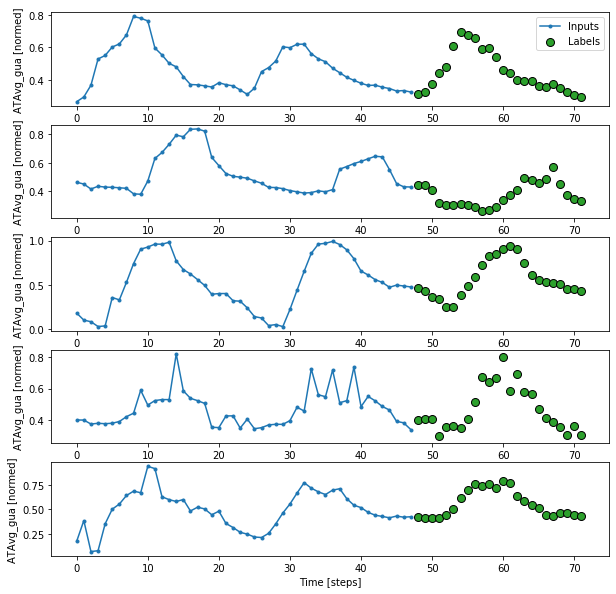

In [51]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

323/323 [==============================] - 1s 3ms/step - loss: 0.0146 - mean_absolute_error: 0.0750
CPU times: user 11min 38s, sys: 2min 28s, total: 14min 7s
Wall time: 4min 43s


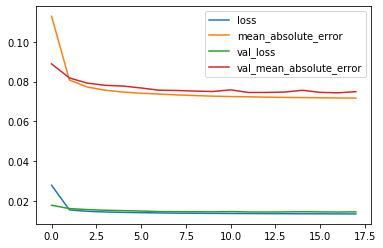

In [52]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)


per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

In [53]:
%%time
accuracy={}
plot_col = vars_to_analize
scaler_type='minmax'
for col in range(len(plot_col)):
    plot_col_index = window.column_indices[plot_col[col]]
    all_preds=[]
    all_labels =[]
    n_batches = len(tuple(window.test))
    for i in range(n_batches):
        #print(f'i = {i}')
        for inputs, labels in window.test.take(i):  # iterate over batches

            numpy_labels = labels.numpy() ### get labels
            numpy_inputs = inputs.numpy() ### get inputs
            preds = multi_lstm_model(numpy_inputs) ### make prediction from trined model
            numpy_preds = preds.numpy() ### get predictions

            all_preds_by_time = []
            all_labels_by_time = []
            
         
            scaler = MinMaxScaler()
            obj = scaler.fit(test_df_raw)

            for j in range(numpy_labels.shape[1]): ## number of time steps
                ### get values for each bacth and time and de-normalize
                #print(f'j = {j}')
                
                batch_pred = obj.inverse_transform(numpy_preds[:,j,:])[:,plot_col_index]
                batch_label = obj.inverse_transform(numpy_labels[:,j,:])[:,plot_col_index]

                all_preds_by_time.extend(batch_pred)
                #print(f'all_preds_by_time = {len(all_preds_by_time)}')
                all_labels_by_time.extend(batch_label)


            all_preds.append(all_preds_by_time)
            all_labels.append(all_labels_by_time)
            if len(all_preds) >= i:
                break

            ## covert to array (shape= i,time*batch_size)
    multi_preds = np.vstack(all_preds)
    multi_labels = np.vstack(all_labels)
    mae_pred = []
    r2_pred = []
    mse_pred =[]
    rmse_pred = []
    for a in np.arange(0,multi_labels.shape[1],step=batch_size):
        multi_labels[:,a:a+batch_size]= np.nan_to_num(multi_labels[:,a:a+batch_size],100) ## substitute NANwith 100 for RH
        multi_preds[:,a:a+batch_size]= np.nan_to_num(multi_preds[:,a:a+batch_size],100)
        
        mae = mean_absolute_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mae_pred.append(mae)
        mse = mean_squared_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mse_pred.append(mse)
        rmse = math.sqrt(mse)
        rmse_pred.append(rmse)
        r2 = round(r2_score(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size]),3)
        r2_pred.append(r2)
    
#         if a == 0:
#             fig, ax = plt.subplots(1, 4, figsize=(20, 5))
#             #plt.suptitle(f'{multi_lstm_model}, window: {window.input_width}_{window.shift}',fontsize = 14)
#             ax[0].plot(df.index, df.mae, '-o',c='#ff5555')
#             ax[0].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[0].set_ylabel(f'MAE {plot_col[col]} [de-normed]')
#             ax[3].plot(df.index, df.r2,'-o', c='#0ca4b4')
#             ax[3].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[3].set_ylabel(f'R2 {plot_col[col]} [de-normed]')
#             ax[1].plot(df.index, df.mse,'-o', c='#ff5555')
#             ax[1].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[1].set_ylabel(f'MSE {plot_col[col]} [de-normed]')
#             ax[2].plot(df.index, df.rmse, '-o',c='#ff5555')
#             ax[2].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[2].set_ylabel(f'RMSE {plot_col[col]} [de-normed]')
    
    
    df = pd.DataFrame(mae_pred, columns=['mae'])
    df['r2']=r2_pred
    df['mse']=mse_pred
    df['rmse']=rmse_pred
    accuracy[plot_col[col]] = {'r2':r2_pred,
                               'mae':mae_pred,
                               'mse': mse_pred,
                               'rmse':rmse_pred}

    
r2 ={}
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = accuracy
pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')

CPU times: user 13min 24s, sys: 2min 18s, total: 15min 43s
Wall time: 8min 19s


## Robust

In [ ]:
## read functions
%run model_utils.ipynb

In [238]:
train_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_train_df_raw.csv')
test_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_test_df_raw.csv')
val_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_val_df_raw.csv')

In [239]:
train_df.set_index('Date_Time', inplace =True)
train_df.index = pd.to_datetime(train_df.index)
test_df.set_index('Date_Time', inplace =True)
test_df.index = pd.to_datetime(test_df.index)
val_df.set_index('Date_Time', inplace =True)
val_df.index = pd.to_datetime(val_df.index)

In [240]:
### make a copy of unscaled data
train_df_raw = train_df.copy()
test_df_raw = test_df.copy()
val_df_raw = val_df.copy()

In [241]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_df[train_df.columns] = scaler.fit_transform(train_df[train_df.columns])
test_df[test_df.columns] = scaler.fit_transform(test_df[test_df.columns])
val_df[val_df.columns] = scaler.fit_transform(val_df[val_df.columns])
scaler_type='robust'
IPython.display.clear_output()

In [242]:
train_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_train_df_{scaler_type}.csv')
test_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_test_df_{scaler_type}.csv')
val_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_val_df_{scaler_type}.csv')

In [243]:
station = 'all'
num_features = train_df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
batch_size  = 32
MAX_EPOCHS = 20
input_width = 48*time_steps
OUT_STEPS =24*time_steps

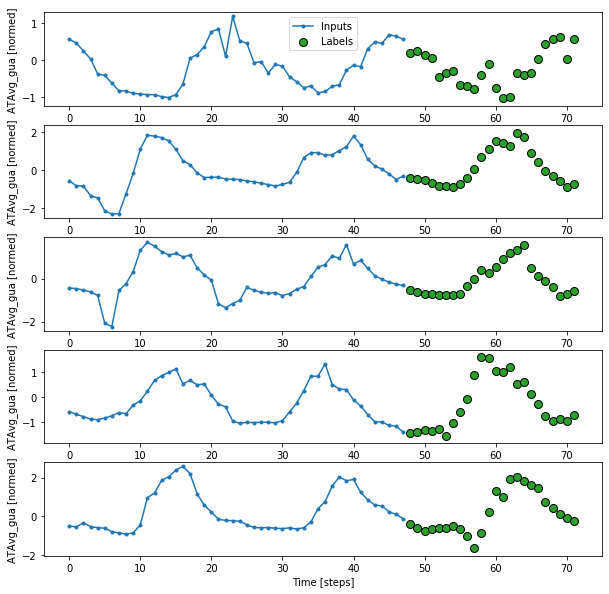

In [244]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

In [ ]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)

losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'robust',plot=False)
pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')


In [ ]:
accuracy={}
plot_col = vars_to_analize
scaler_type='robust'
col = 0
for col in range(len(plot_col)):
    plot_col_index = window.column_indices[plot_col[col]]
    all_preds=[]
    all_labels =[]
    n_batches = len(tuple(window.test))
    for i in range(n_batches):
        #print(f'i = {i}')
        for inputs, labels in window.test.take(i):  # iterate over batches

            numpy_labels = labels.numpy() ### get labels
            numpy_inputs = inputs.numpy() ### get inputs
            preds = multi_lstm_model(numpy_inputs) ### make prediction from trined model
            numpy_preds = preds.numpy() ### get predictions

            all_preds_by_time = []
            all_labels_by_time = []
            
         
            scaler = RobustScaler()
            obj = scaler.fit(test_df_raw)

            for j in range(numpy_labels.shape[1]): ## number of time steps
                ### get values for each bacth and time and de-normalize
                #print(f'j = {j}')
                
                batch_pred = obj.inverse_transform(numpy_preds[:,j,:])[:,plot_col_index]
                batch_label = obj.inverse_transform(numpy_labels[:,j,:])[:,plot_col_index]

                all_preds_by_time.extend(batch_pred)
                #print(f'all_preds_by_time = {len(all_preds_by_time)}')
                all_labels_by_time.extend(batch_label)


            all_preds.append(all_preds_by_time)
            all_labels.append(all_labels_by_time)
            if len(all_preds) >= i:
                break

            ## covert to array (shape= i,time*batch_size)
    multi_preds = np.vstack(all_preds)
    multi_labels = np.vstack(all_labels)
    mae_pred = []
    r2_pred = []
    mse_pred =[]
    rmse_pred = []
    for a in np.arange(0,multi_labels.shape[1],step=batch_size):
        mae = mean_absolute_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mae_pred.append(mae)
        mse = mean_squared_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mse_pred.append(mse)
        rmse = math.sqrt(mse)
        rmse_pred.append(rmse)
        r2 = round(r2_score(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size]),3)
        r2_pred.append(r2)
    df = pd.DataFrame(mae_pred, columns=['mae'])
    df['r2']=r2_pred
    df['mse']=mse_pred
    df['rmse']=rmse_pred
    accuracy[plot_col[col]] = {'r2':r2_pred,
                               'mae':mae_pred,
                               'mse': mse_pred,
                               'rmse':rmse_pred}

    if a == 0:
        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        #plt.suptitle(f'{multi_lstm_model}, window: {window.input_width}_{window.shift}',fontsize = 14)
        ax[0].plot(df.index, df.mae, '-o',c='#ff5555')
        ax[0].set_xlabel(f'prediction times {plot_col[col]}')
        ax[0].set_ylabel(f'MAE {plot_col[col]} [de-normed]')
        ax[3].plot(df.index, df.r2,'-o', c='#0ca4b4')
        ax[3].set_xlabel(f'prediction times {plot_col[col]}')
        ax[3].set_ylabel(f'R2 {plot_col[col]} [de-normed]')
        ax[1].plot(df.index, df.mse,'-o', c='#ff5555')
        ax[1].set_xlabel(f'prediction times {plot_col[col]}')
        ax[1].set_ylabel(f'MSE {plot_col[col]} [de-normed]')
        ax[2].plot(df.index, df.rmse, '-o',c='#ff5555')
        ax[2].set_xlabel(f'prediction times {plot_col[col]}')
        ax[2].set_ylabel(f'RMSE {plot_col[col]} [de-normed]')
        
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = accuracy
pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')

In [360]:
r2 ={}
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = accuracy
pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')

## Power

In [ ]:
## read functions
%run model_utils.ipynb

In [361]:
train_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_train_df_raw.csv')
test_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_test_df_raw.csv')
val_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_val_df_raw.csv')

In [362]:
train_df.set_index('Date_Time', inplace =True)
train_df.index = pd.to_datetime(train_df.index)
test_df.set_index('Date_Time', inplace =True)
test_df.index = pd.to_datetime(test_df.index)
val_df.set_index('Date_Time', inplace =True)
val_df.index = pd.to_datetime(val_df.index)

In [363]:
### make a copy of unscaled data
train_df_raw = train_df.copy()
test_df_raw = test_df.copy()
val_df_raw = val_df.copy()

In [364]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer()
train_df[train_df.columns] = scaler.fit_transform(train_df[train_df.columns])
test_df[test_df.columns] = scaler.fit_transform(test_df[test_df.columns])
val_df[val_df.columns] = scaler.fit_transform(val_df[val_df.columns])
scaler_type='power'
IPython.display.clear_output()

In [365]:
train_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_train_df_{scaler_type}.csv')
test_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_test_df_{scaler_type}.csv')
val_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_val_df_{scaler_type}.csv')

In [366]:
station = 'all'
num_features = train_df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
batch_size  = 32
MAX_EPOCHS = 20
input_width = 48*time_steps
OUT_STEPS =24*time_steps

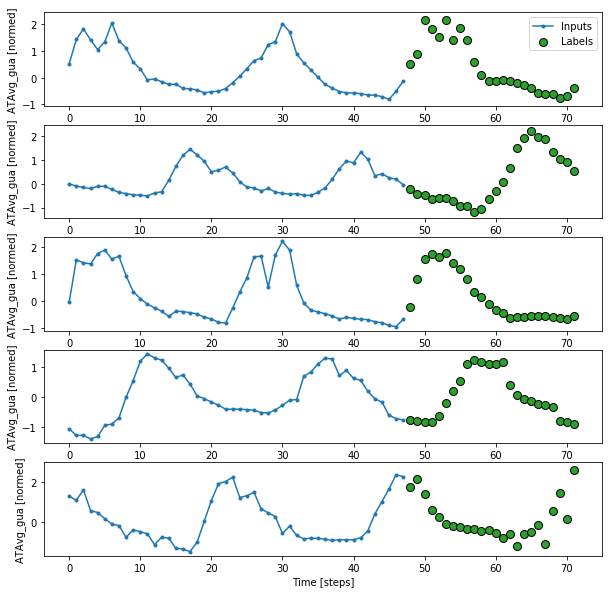

In [367]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

323/323 [==============================] - 1s 3ms/step - loss: 0.3451 - mean_absolute_error: 0.3623
CPU times: user 4min 48s, sys: 1min 1s, total: 5min 50s
Wall time: 1min 59s


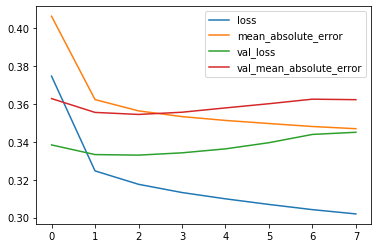

In [368]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)


losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)

val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
#r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = window.get_predictions(model=multi_lstm_model,plot_col =vars_to_analize, scaler_type = 'power',plot=False)
#pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')



In [ ]:
accuracy={}
plot_col = vars_to_analize
scaler_type='power'
for col in range(len(plot_col)):
    plot_col_index = window.column_indices[plot_col[col]]
    all_preds=[]
    all_labels =[]
    n_batches = len(tuple(window.test))
    for i in range(n_batches):
        #print(f'i = {i}')
        for inputs, labels in window.test.take(i):  # iterate over batches

            numpy_labels = labels.numpy() ### get labels
            numpy_inputs = inputs.numpy() ### get inputs
            preds = multi_lstm_model(numpy_inputs) ### make prediction from trined model
            numpy_preds = preds.numpy() ### get predictions

            all_preds_by_time = []
            all_labels_by_time = []
            
         
            scaler = PowerTransformer()
            obj = scaler.fit(test_df_raw)

            for j in range(numpy_labels.shape[1]): ## number of time steps
                ### get values for each bacth and time and de-normalize
                #print(f'j = {j}')
                
                batch_pred = obj.inverse_transform(numpy_preds[:,j,:])[:,plot_col_index]
                batch_label = obj.inverse_transform(numpy_labels[:,j,:])[:,plot_col_index]

                all_preds_by_time.extend(batch_pred)
                #print(f'all_preds_by_time = {len(all_preds_by_time)}')
                all_labels_by_time.extend(batch_label)


            all_preds.append(all_preds_by_time)
            all_labels.append(all_labels_by_time)
            if len(all_preds) >= i:
                break

            ## covert to array (shape= i,time*batch_size)
    multi_preds = np.vstack(all_preds)
    multi_labels = np.vstack(all_labels)
    mae_pred = []
    r2_pred = []
    mse_pred =[]
    rmse_pred = []
    for a in np.arange(0,multi_labels.shape[1],step=batch_size):
        multi_labels[:,a:a+batch_size]= np.nan_to_num(multi_labels[:,a:a+batch_size],100) ## substitute NANwith 100 for RH
        multi_preds[:,a:a+batch_size]= np.nan_to_num(multi_preds[:,a:a+batch_size],100)
        
        mae = mean_absolute_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mae_pred.append(mae)
        mse = mean_squared_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mse_pred.append(mse)
        rmse = math.sqrt(mse)
        rmse_pred.append(rmse)
        r2 = round(r2_score(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size]),3)
        r2_pred.append(r2)
    df = pd.DataFrame(mae_pred, columns=['mae'])
    df['r2']=r2_pred
    df['mse']=mse_pred
    df['rmse']=rmse_pred
    accuracy[plot_col[col]] = {'r2':r2_pred,
                               'mae':mae_pred,
                               'mse': mse_pred,
                               'rmse':rmse_pred}

    if a == 0:
        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        #plt.suptitle(f'{multi_lstm_model}, window: {window.input_width}_{window.shift}',fontsize = 14)
        ax[0].plot(df.index, df.mae, '-o',c='#ff5555')
        ax[0].set_xlabel(f'prediction times {plot_col[col]}')
        ax[0].set_ylabel(f'MAE {plot_col[col]} [de-normed]')
        ax[3].plot(df.index, df.r2,'-o', c='#0ca4b4')
        ax[3].set_xlabel(f'prediction times {plot_col[col]}')
        ax[3].set_ylabel(f'R2 {plot_col[col]} [de-normed]')
        ax[1].plot(df.index, df.mse,'-o', c='#ff5555')
        ax[1].set_xlabel(f'prediction times {plot_col[col]}')
        ax[1].set_ylabel(f'MSE {plot_col[col]} [de-normed]')
        ax[2].plot(df.index, df.rmse, '-o',c='#ff5555')
        ax[2].set_xlabel(f'prediction times {plot_col[col]}')
        ax[2].set_ylabel(f'RMSE {plot_col[col]} [de-normed]')

r2 ={}
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = accuracy
pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')

In [413]:
col

15

In [415]:
np.isnan(multi_preds[:,a:a+batch_size]).any()

True

In [388]:
multi_labels[:,a:a+batch_size]= np.nan_to_num(multi_labels[:,a:a+batch_size],100)
mean_absolute_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])

4.9767985

## Standard

In [ ]:
## read functions
%run model_utils.ipynb

In [2]:
train_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_train_df_raw.csv')
test_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_test_df_raw.csv')
val_df= pd.read_csv('data/PROCESSED/TRAIN_TEST_VAL/all_val_df_raw.csv')

In [3]:
train_df.set_index('Date_Time', inplace =True)
train_df.index = pd.to_datetime(train_df.index)
test_df.set_index('Date_Time', inplace =True)
test_df.index = pd.to_datetime(test_df.index)
val_df.set_index('Date_Time', inplace =True)
val_df.index = pd.to_datetime(val_df.index)

In [4]:
### make a copy of unscaled data
train_df_raw = train_df.copy()
test_df_raw = test_df.copy()
val_df_raw = val_df.copy()

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df[train_df.columns] = scaler.fit_transform(train_df[train_df.columns])
test_df[test_df.columns] = scaler.fit_transform(test_df[test_df.columns])
val_df[val_df.columns] = scaler.fit_transform(val_df[val_df.columns])
scaler_type='stand'
IPython.display.clear_output()

In [6]:
train_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_train_df_{scaler_type}.csv')
test_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_test_df_{scaler_type}.csv')
val_df.to_csv(f'data/PROCESSED/TRAIN_TEST_VAL/all_val_df_{scaler_type}.csv')

In [9]:
## Select variables of interest
r = re.compile(f'ATAvg.*') # only csv files
temp = list(filter(r.match, list(train_df.columns))) 

r = re.compile(f'RHAvg.*') # only csv files
rh = list(filter(r.match, list(train_df.columns))) 

In [12]:
station = 'all'
num_features = train_df.shape[1]
vars_to_analize = temp+rh ## get temperature and rel humidity variables
batch_size  = 32
MAX_EPOCHS = 20
input_width = 48*time_steps
OUT_STEPS =24*time_steps

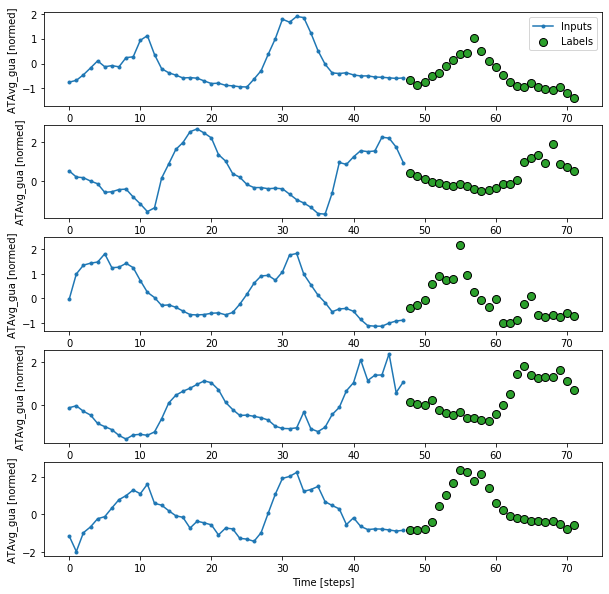

In [15]:
multi_val_performance = {}
multi_performance = {}
r2 ={}

## window
window = WindowGenerator(
input_width=input_width, label_width=OUT_STEPS, shift=OUT_STEPS)
window.plot(plot_col=list(window.column_indices.keys())[0])

323/323 [==============================] - 2s 5ms/step - loss: 0.3453 - mean_absolute_error: 0.3630
CPU times: user 5min 42s, sys: 1min 11s, total: 6min 54s
Wall time: 2min 25s


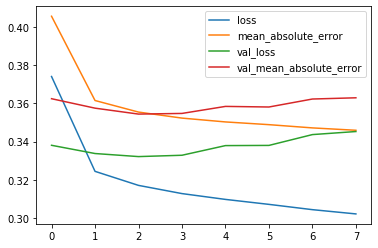

In [16]:
%%time
### RNN
print(f'RNN')

multi_lstm_model = tf.keras.Sequential([
# Shape [batch, time, features] => [batch, lstm_units]
# Adding more `lstm_units` just overfits more quickly.
tf.keras.layers.LSTM(batch_size, return_sequences=False),
# Shape => [batch, out_steps*features]
tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
# Shape => [batch, out_steps, features]
tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, window)

IPython.display.clear_output()
multi_val_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.val)
multi_performance[f'MultiLSTM_model_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = multi_lstm_model.evaluate(window.test, verbose=0)


losses = pd.DataFrame(history.history)
losses.plot()
plt.savefig(f'{path}/{station}_multi_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_losses.png',dpi=100)


per = pd.DataFrame.from_dict(multi_performance, orient='index',columns=['loss_test','mae_test'])
val= pd.DataFrame.from_dict(multi_val_performance, orient='index',columns=['loss_val','mae_val'])
pd.merge(per, val, how='inner',left_index=True, right_index =True).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_overall.csv')

In [17]:
%%time
accuracy={}
plot_col = vars_to_analize
scaler_type='stand'
for col in range(len(plot_col)):
    plot_col_index = window.column_indices[plot_col[col]]
    all_preds=[]
    all_labels =[]
    n_batches = len(tuple(window.test))
    for i in range(n_batches):
        #print(f'i = {i}')
        for inputs, labels in window.test.take(i):  # iterate over batches

            numpy_labels = labels.numpy() ### get labels
            numpy_inputs = inputs.numpy() ### get inputs
            preds = multi_lstm_model(numpy_inputs) ### make prediction from trined model
            numpy_preds = preds.numpy() ### get predictions

            all_preds_by_time = []
            all_labels_by_time = []
            
         
            scaler = StandardScaler()
            obj = scaler.fit(test_df_raw)

            for j in range(numpy_labels.shape[1]): ## number of time steps
                ### get values for each bacth and time and de-normalize
                #print(f'j = {j}')
                
                batch_pred = obj.inverse_transform(numpy_preds[:,j,:])[:,plot_col_index]
                batch_label = obj.inverse_transform(numpy_labels[:,j,:])[:,plot_col_index]

                all_preds_by_time.extend(batch_pred)
                #print(f'all_preds_by_time = {len(all_preds_by_time)}')
                all_labels_by_time.extend(batch_label)


            all_preds.append(all_preds_by_time)
            all_labels.append(all_labels_by_time)
            if len(all_preds) >= i:
                break

            ## covert to array (shape= i,time*batch_size)
    multi_preds = np.vstack(all_preds)
    multi_labels = np.vstack(all_labels)
    mae_pred = []
    r2_pred = []
    mse_pred =[]
    rmse_pred = []
    for a in np.arange(0,multi_labels.shape[1],step=batch_size):
        multi_labels[:,a:a+batch_size]= np.nan_to_num(multi_labels[:,a:a+batch_size],100) ## substitute NANwith 100 for RH
        multi_preds[:,a:a+batch_size]= np.nan_to_num(multi_preds[:,a:a+batch_size],100)
        
        mae = mean_absolute_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mae_pred.append(mae)
        mse = mean_squared_error(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size])
        mse_pred.append(mse)
        rmse = math.sqrt(mse)
        rmse_pred.append(rmse)
        r2 = round(r2_score(multi_labels[:,a:a+batch_size], multi_preds[:,a:a+batch_size]),3)
        r2_pred.append(r2)
    
#         if a == 0:
#             fig, ax = plt.subplots(1, 4, figsize=(20, 5))
#             #plt.suptitle(f'{multi_lstm_model}, window: {window.input_width}_{window.shift}',fontsize = 14)
#             ax[0].plot(df.index, df.mae, '-o',c='#ff5555')
#             ax[0].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[0].set_ylabel(f'MAE {plot_col[col]} [de-normed]')
#             ax[3].plot(df.index, df.r2,'-o', c='#0ca4b4')
#             ax[3].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[3].set_ylabel(f'R2 {plot_col[col]} [de-normed]')
#             ax[1].plot(df.index, df.mse,'-o', c='#ff5555')
#             ax[1].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[1].set_ylabel(f'MSE {plot_col[col]} [de-normed]')
#             ax[2].plot(df.index, df.rmse, '-o',c='#ff5555')
#             ax[2].set_xlabel(f'prediction times {plot_col[col]}')
#             ax[2].set_ylabel(f'RMSE {plot_col[col]} [de-normed]')
    
    
    df = pd.DataFrame(mae_pred, columns=['mae'])
    df['r2']=r2_pred
    df['mse']=mse_pred
    df['rmse']=rmse_pred
    accuracy[plot_col[col]] = {'r2':r2_pred,
                               'mae':mae_pred,
                               'mse': mse_pred,
                               'rmse':rmse_pred}

    
r2 ={}
r2[f'MultiLSTM_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}'] = accuracy
pd.concat({k: pd.DataFrame(v).T for k, v in r2.items()}, axis=0).to_csv(f'{path}/{station}_lstm-{batch_size}-var-{scaler_type}_{sample_freq}m_w{input_width}_{OUT_STEPS}_{MAX_EPOCHS}_performance_times.csv')

CPU times: user 13min 25s, sys: 2min 23s, total: 15min 48s
Wall time: 8min 33s
